In [ ]:
import numpy as np
import re
from time import time
import json
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model
from keras.preprocessing import image
import pickle

In [ ]:
 # Read text captions
    
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
captions = readTextFile("/content/drive/MyDrive/Image Captioning/captions.txt")
captions = captions.split('\n')[1:-1]

In [ ]:
captions[4]

'1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .'

In [ ]:
# Dictionary to map each image to list of captions it has

descriptions = {}

for x in captions:
    img_name,caption = x.split('.jpg,')
    
    # if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(caption)

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

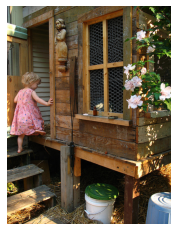

In [ ]:
IMG_PATH = "/content/drive/MyDrive/Image Captioning/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH + "1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(img)
plt.show()

In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [ ]:
# Clean captions

for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [ ]:
# Total no of words across all sentences

total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373803


In [ ]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [ ]:
# Filter words from vocab according to certain threshold freq

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
#print(freq_cnt)

In [ ]:
# sort this dictionary according to freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
len(total_words)

1845

In [ ]:
train_file_data = readTextFile("/content/drive/MyDrive/Image Captioning/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/MyDrive/Image Captioning/Flickr_8k.testImages.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# Prepare description for the training data
# Tweak - Add <s> and <e> token to our data

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [ ]:
#train_descriptions['1000268201_693b08cb0e']

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 130s 1us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) # reshape to (1,224,224,3)
    # Noramalisation
    img = preprocess_input(img)
    return img

In [ ]:
#img = preprocess_img(IMG_PATH + "1000268201_693b08cb0e.jpg")
#print(img.shape)
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [ ]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,1))
    return feature_vector

In [ ]:
encode_img(IMG_PATH + "1000268201_693b08cb0e.jpg")

array([[0.06535938],
       [0.16782546],
       [0.32517588],
       ...,
       [0.05107139],
       [0.32821164],
       [1.0043377 ]], dtype=float32)

In [ ]:
start = time()
encoding_train = {}
# image_id -> feature vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH + "/" + img_id + '.jpg'
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
    
end_t = time()
print("Time taken : ",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
start = time()
encoding_test = {}
# image_id -> feature vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH + "/" + img_id + '.jpg'
    encoding_test[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
    
end_t = time()
print("Time taken : ",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Time taken :  784.112818479538


In [ ]:
# Store everything to the disk //

with open("encoded_train_features.pkl",'wb') as f:
    pickle.dump(encoding_train,f)

  
with open("encoded_test_features.pkl",'wb') as f:
    pickle.dump(encoding_test,f)

In [ ]:
# Load data training and testing

with open("/content/drive/MyDrive/Image Captioning/encoded_train_features.pkl",'rb') as f:
    encoding_train = pickle.load(f)
    
with open("/content/drive/MyDrive/Image Captioning/encoded_test_features.pkl",'rb') as f:
    encoding_test = pickle.load(f)

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
print(len(idx_to_word))

1845


In [ ]:
# Two special words

word_to_idx["startseq"] = 1846
idx_to_word[1846] = "startseq"

word_to_idx["endseq"] = 1847
idx_to_word[1847] = "endseq"

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [ ]:
max_len = 0

for key in train_descriptions.keys():
    for cap in descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

33


In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # 0 denote padding
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    
                    X1,X2,y = [],[],[]
                    n=0

In [ ]:
f = open("/content/drive/MyDrive/Image Captioning/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    
f.close()

In [ ]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


In [ ]:
input_img_feature = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_feature)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
# captions as input
input_caption = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_caption)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#combined Model
model = Model(inputs=[input_img_feature,input_caption],outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# Embedding-layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(optimizer='adam',loss='categorical_crossentropy')

In [ ]:
epochs = 200
batch_size = 3
steps = len(train_descriptions)/batch_size

In [ ]:
for i in range(54,epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

2000/2000 [==============================] - 176s 88ms/step - loss: 2.1719


In [ ]:
model.load_weights("/content/drive/MyDrive/Image Captioning/model_weights/model_70.h5")

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()  # word with max prob always
        word = idx_to_word[ypred]
        in_text += ' ' + word
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

(1, 2048)


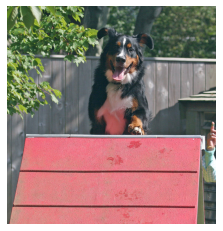

dog jumps over hurdle
(1, 2048)


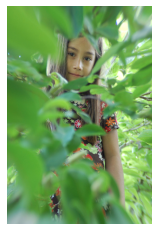

little girl in flowery shirt is pointing in the air
(1, 2048)


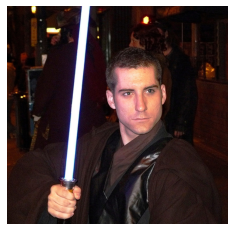

man in red shirt is holding up sign
(1, 2048)


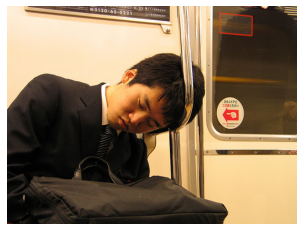

man in black shirt is sitting in chair with his hand on his hand
(1, 2048)


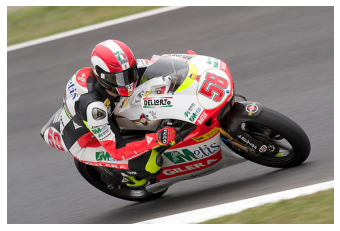

motorcyclist on motorcycle is driving on dirt track
(1, 2048)


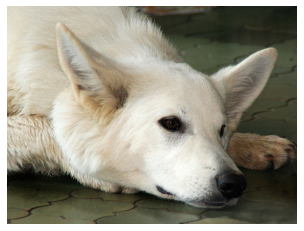

white dog is drinking water from logs
(1, 2048)


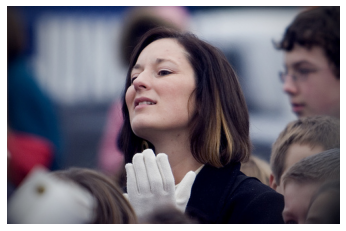

two women are wearing black and matching outfits
(1, 2048)


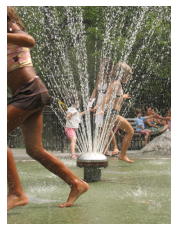

boy in blue swim trunks is pouring in the water
(1, 2048)


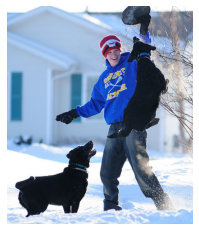

two children play hockey in snow
(1, 2048)


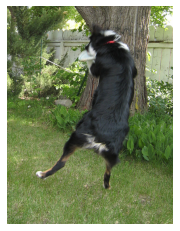

dog jumps up to catch ball in its mouth
(1, 2048)


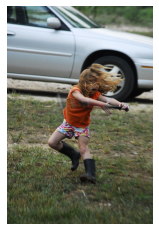

boy in shorts is playing with football
(1, 2048)


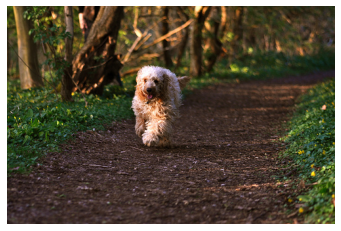

dog is running through the grass
(1, 2048)


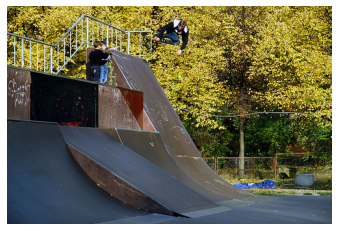

man in jeans is skateboarding on red board
(1, 2048)


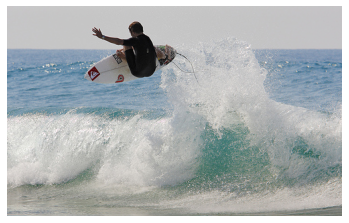

surfer in black wetsuit surfs on huge wave
(1, 2048)


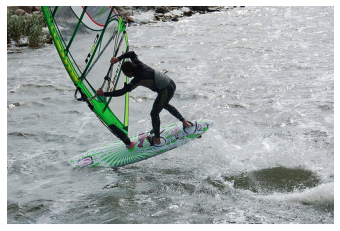

man is snowboarding down waterfall


In [ ]:
# Pick some random images and show result

for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    image_name = all_img_names[idx]
    photo_2048 = encode_img(IMG_PATH+image_name+'.jpg').reshape((1,2048))
    print(photo_2048.shape)

    
    i = plt.imread(IMG_PATH+image_name+'.jpg')
    plt.axis("off")
    plt.imshow(i)
    plt.show()
    caption = predict_caption(photo_2048)
    print(caption)

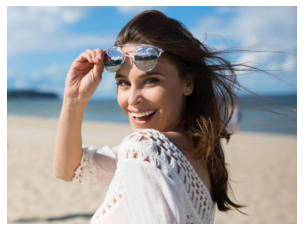

woman with sunglasses and blue shirt and black shirt is standing on the beach


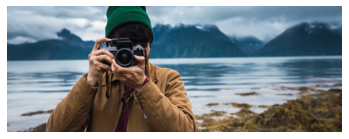

man in blue shirt is sitting on rock overlooking the ocean


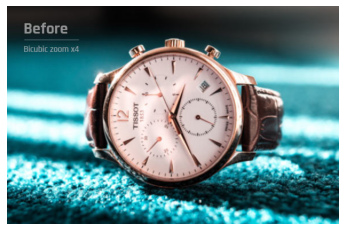

man in red shirt is gathering in the ocean


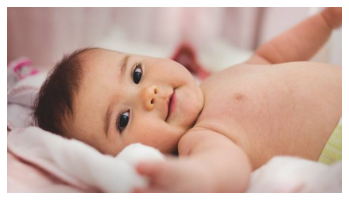

baby with spiderman hair is laying on the grass


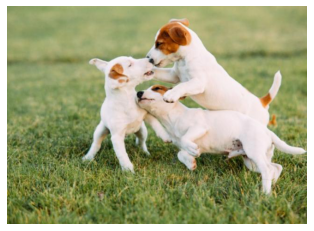

two dogs are running through field of green grass


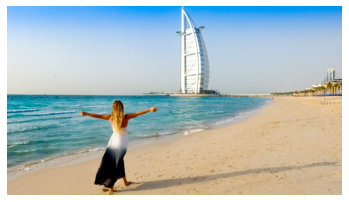

man in black shorts hits ball in the air


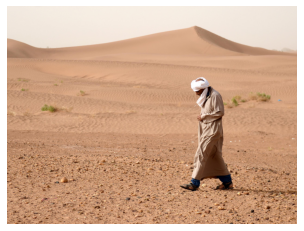

two men are taking picture of the water


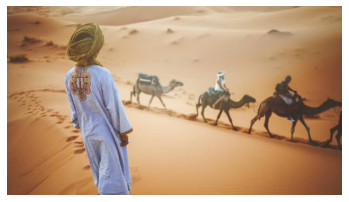

two girls are standing on the side of the rock posing


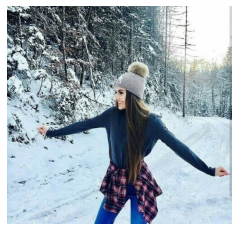

boy in black suit is running through the water


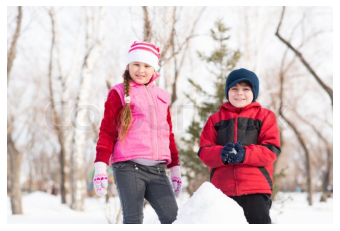

two people are standing in front of some snow


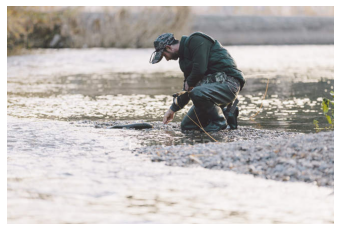

boy in blue shirt is jumping off of swing


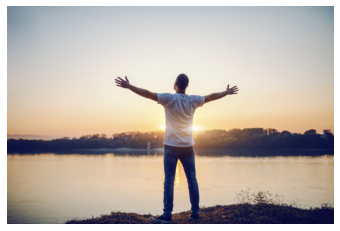

person is flying in the air while standing on the water


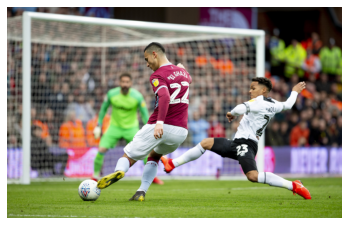

soccer player in red uniform hit the ball


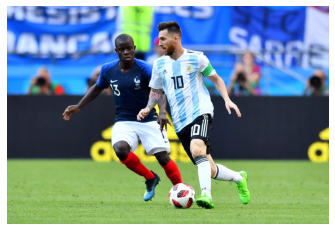

soccer player in red uniform about to hit ball


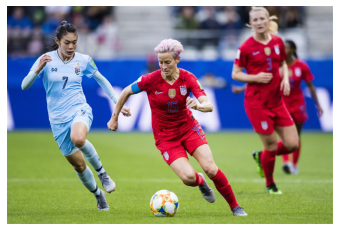

soccer player in red uniform about to hit ball


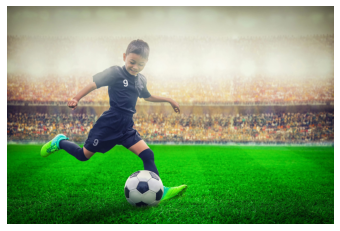

the boy in the red shirt is falling down the soccer ball in the air


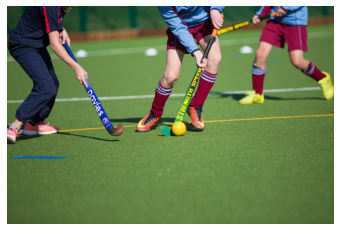

soccer player in red and white uniform is almost by the ball


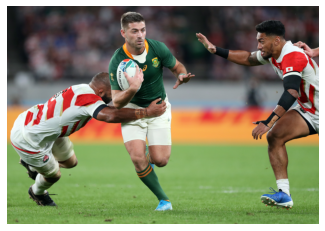

soccer player in red uniform about to hit ball


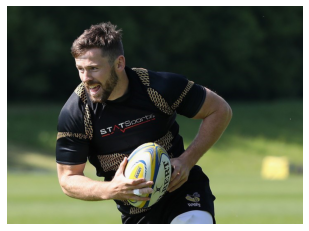

man in orange shirt and headphones is playing football


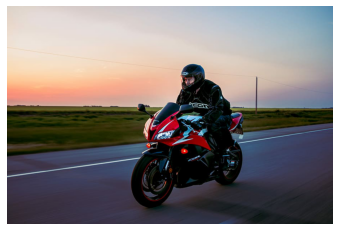

man on motorcycle is riding on dirt track


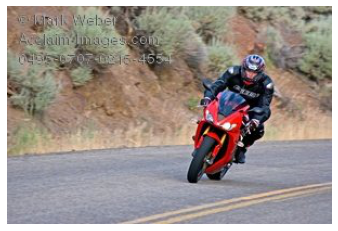

man on motorcycle riding on road


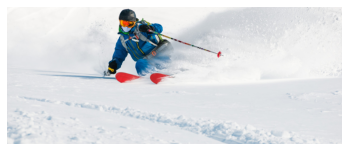

child in red coat is skiing down snowy hill


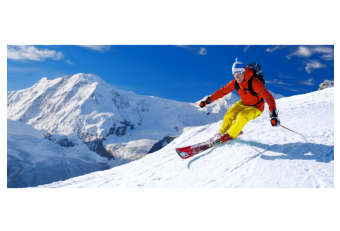

two skiers are making their on mountain slope


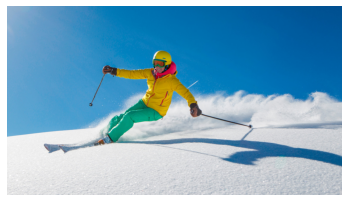

young boy in red shirt is jumping on snowboard


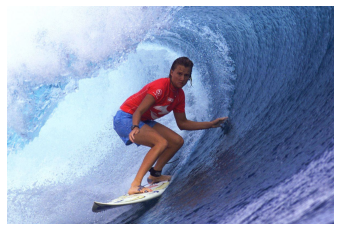

man in swimming trunks is jumping off pool


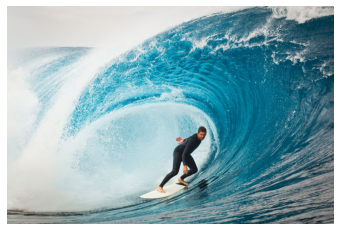

man in swimming trunks is riding big wave


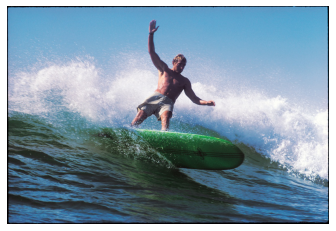

man in wetsuit is surfing in the ocean


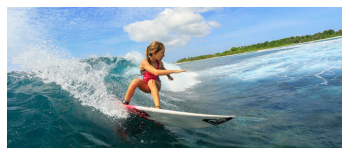

man in blue surfs on the shore of the ocean


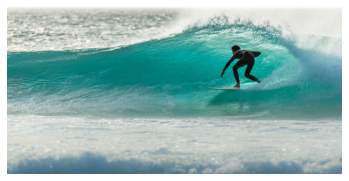

surfer is riding the waves


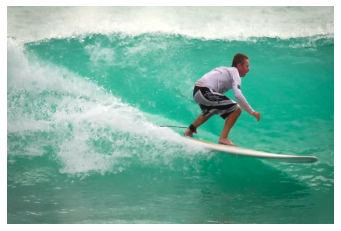

man in wetsuit is surfing in the ocean


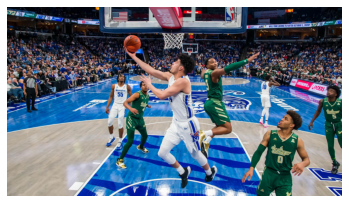

group of men are sitting in the race speed


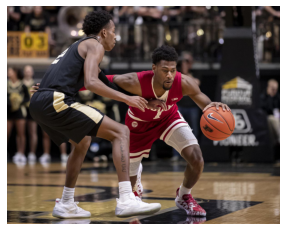

the basketball player in the orange uniform is trying to make shot


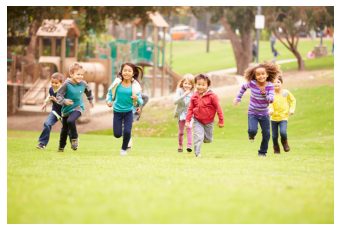

group of young men are playing soccer


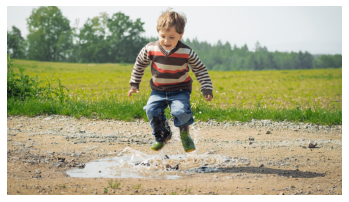

boy in red shirt is running through field


In [ ]:
import os
PATH = "/content/drive/MyDrive/Image Captioning/image caption test/"


for img in os.listdir(PATH):

    img_path = os.path.join(PATH,img)
    photo_2048 = encode_img(img_path).reshape((1,2048))

    
    i = plt.imread(img_path)
    plt.axis("off")
    plt.imshow(i)
    plt.show()
    caption = predict_caption(photo_2048)
    print(caption)